---
title: Common pitfalls and practical considerations for ranking metrics
author: Hongsup Shin
date: 2025-02-08
categories: [ML, Learning-to-rank]
description: Test
# image: Fig.png
format:
  html:
    code-fold: true
---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

Ranking is everywhere. When you search for products online or scroll through your social media feed, you're interacting with ranking systems. Unlike classification where we simply predict a category, ranking requires ordering items by their relevance or importance. This fundamental difference requires specific metrics so-called information retrieval (IR) metrics that capture nuanced aspects of ranking quality. Choosing the right ranking metric requires good understanding of reward, discount, and normalization of ranking metrics. In this post, we will discuss mathematical properties of various ranking metrics, focusing on common pitfalls in practice and how to address them. Let's start with some basics.

## Why ranking is different

A good way to understand ranking is to compare it against classification. Let's say, we have a dataset with three relevance grades: excellent, good, and mediocre. We can train a multi-class classifier to predict the probability of a sample belonging to each grade. In learning-to-rank (LTR) framework, this is called point-wise ranking approach. However, at the core, ranking is about understanding relative relationship among different samples, and thus, more preferred LTR models take pair-wise or list-wise approach. 

This consideration of multi-sample comparison is related to how LTR is used in practice. When retrieving relevant documents or optimizing search query, we work with multiple queries. This means, we want to generalize the model to learn the relative importance of samples across multiple datasets. This is why a typical LTR dataset contains a group variable that indicates group or query membership. This also means that in some groups, we might not always all relevance labels. For instance, in the three-grade example, we might have a query group where we only have samples that belong to "excellent" and "mediocre", without the "good" grade. A classifier will complain about this but LTR optimization loss can naturally handle this.

Finally and most importantly, ranking deals with positional bias. We can train a model that optimizes the ranking of *all* items in a dataset, but in practice, we normally care about the small majority at the top (i.e., top K). This leads to more complex use cases and metrics such as whether only the top first item matters or top 10 items, or how we penalize model when it makes errors. Related to this, compared to classification, partial correctness exists in ranking systems. Even when model prediction does not result in a perfect ranking, loss can be computed by considering how far it is from the ideal ranking.

## Mean reciprocal rank (MRR)

Ranking metrics are naturally designed to digest the positional information (ranks) of relevant items retrieved. Mean reciprocal rank (MRR) is a good example where the metric is solely computed by ranks. Mathematically, MRR is defined as:

$$ \text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rank}_i} $$

where $\text{rank}_i$ refers to the rank of the **first** relevant item of $i$th query from a set of queries, $Q$. In other words, MRR is the *inverse* of the harmonic mean of ranks of the first relevant items. This also indicates that MRR's focus is a single item, not the overall quality of ranking of an array.

### Hyperbolic discount of reward

Since we use reciprocal rank (RR), $\frac{1}{\text{rank}_i}$, individual RR scores shows *hyperbolic* decay:

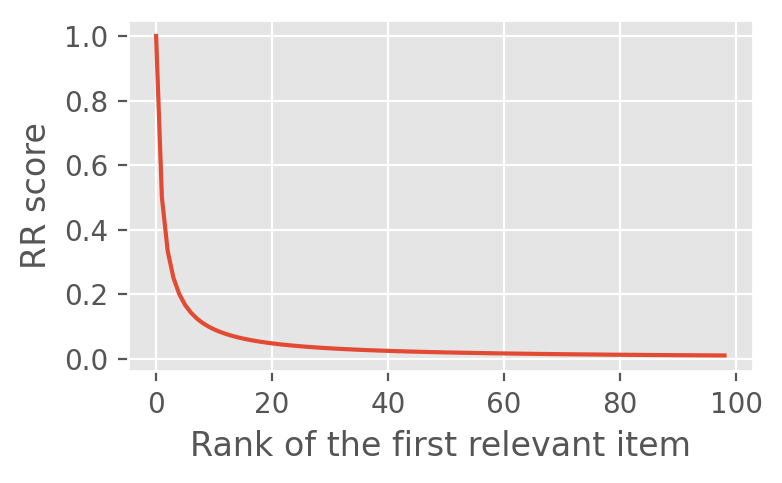

In [7]:
#| label: fig-1
#| fig-cap: "Hyperbolic decay of reciprocal rank (RR)"
#| fig-align: "center"
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
ax.plot(1 / np.arange(1, 100))
ax.set(xlabel='Rank of the first relevant item', ylabel='RR score')
fig.tight_layout()

This hyperbolic decay means the RR score difference between **$i$th and $i+k$th item is much larger when $i$ is small**. For instance, the difference between getting the relevant item in the first vs. second place is much larger than getting the relevant item in the 100th vs. the 101th places.

Naturally, it means that a small number queries with low rank values (higher RR scores) can significantly outweigh multiple queries with higher rank values. This implies that MRR might be less sensitive to outliers because the mean (MRR) does not change dramatically when we occasionally have bad results (higher rank values). However, at the same time this means comparing MRR alone might not be enough to understand the subtle score difference.

Assume that we have three queries, and system A returns the first relevant item at ranks 1, 2 and 4, respectively, while system B returns the relevant items in each case at rank 2:

|  | $Q_{1}$ | $Q_{2}$ | $Q_{3}$ | MRR |
|--|--|--|--|--|
|System A| 1| 2| 4| 1/3 x (1 + 2 + 4) = **0.58**|
|System B| 2| 2| 2| 1/3 x (2 + 2 + 2) = **0.5**|

In this example, we should be choosing A because $\text{MRR}_{A} > \text{MRR}_{B}$, but as the example shows, the truth is more nuanced. 

### The harmonic nature of rankings

The hyperbolic discount of RR scores is why MRR uses harmonic mean instead of arithmetic mean of ranks. As RR front-load 

- why harmonic mean matters
- sometimes inverse of MRR is more intuitive
- harmonic variance is difficult to calculate

MRR: hyperbolic decay
- i vs. i+k diff matters more when i is smaller -> hyperbolic decay
- MRR can be dominated by a few relevant small outliers (really good ones)
- computing variance is pretty complicated; theoretical understanding of 




- What to reward (relevance scales, binary vs graded)
- How to discount (position bias models)
- How to normalize (different approaches)
- Deep dive: Variants of the same metric
  - NDCG variants and their behavioral differences
  - MAP variants (fixed K vs variable K) and their purposes
  - When to use which variant

## 3. The Harmonic Nature of Rankings
- MRR and harmonic mean connection
- Why arithmetic mean fails for rankings
- Connections to other domains
  - Parallel processing
  - Circuit analysis
- Implications for metric choice

## 4. Common Pitfalls and Practical Considerations
- The K Parameter Dilemma
  - Why larger K isn't always better
  - Computational considerations
  - User behavior alignment
  - Statistical stability
  - Example: Same ranking, different K values
- Poor Performance Scenarios
  - How different metrics behave with bad rankings
  - Case studies with different types of poor rankings
  - Implications for early-stage development
- Comparing Metrics Correctly
  - Why NDCG@10 = 0.9 ≠ NDCG@100 = 0.9
  - Choosing appropriate K values
  - Common comparison mistakes

## 5. The Optimization Challenge
- Why traditional metrics are hard to optimize
- Modern approaches (xe_ndcg case study)
- Trade-offs between accuracy and optimizability
- Connecting metric properties to optimization difficulties

## 6. Bringing It All Together
- How metric choice affects optimization strategy
- Practical recommendations for different scenarios
- When to use which metric and why